## 3 - Image Classification

John Wu - 260612056

Consider an automobile restoration company which receives thousands of vehicles per day. The company hires you to build a system which can automatically identify the manufacturer of the automobile so that it can be sent to the particular repair center. You recall the Introduction to Computer Vision course that you took during Fall of 2018 and decide to build a logo classiﬁcation system using Histogram of Gradient (HoG) features. The company provides you some images of diﬀerent manufacturers’ logos, as your training images that are taken in an ideal setting (i.e. no additional background or perspective distortion) and you are asked to test your built system on real-world images (i.e. with background and perspective distortion).

### 3.1 - Coding Questions
For this task, you are given a set of training images (check ‘dataset’ folder): ﬁve logos of ‘Ford’ and ﬁve logos of ‘Volkswagen’ (see Figure 2). You are also given two real-world test images, one for each manufacturer. Use class label 1 for ‘Ford’ and -1 for ‘Volkswagen’. Build a classiﬁcation system using HoG features as follows: 

#### Part I - Training

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.neighbors import KNeighborsClassifier

# store images in train and test
ford_train, ford_test = [], []
volks_train, volks_test = [], []

# load, resize, and store images
for file in os.listdir('./dataset/'):
    img = cv2.imread('./dataset/' + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(128,128))
    if file.startswith('ford_train'): 
        ford_train.append(img)
    elif file.startswith('ford_test'):
        ford_test.append(img)
    elif file.startswith('volks_train'): 
        volks_train.append(img)
    elif file.startswith('volks_test'): 
        volks_test.append(img)  

print('Images Loaded and Resized to 128x128:')
print('Ford - {} training images, {} testing image'.format(len(ford_train), len(ford_test)))
print('Volkswagon - {} training images, {} testing image'.format(len(volks_train), len(volks_test)))
    
    

Images Loaded and Resized to 128x128:
Ford - 5 training images, 1 testing image
Volkswagon - 5 training images, 1 testing image


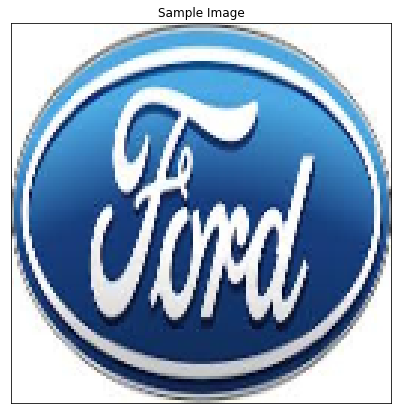

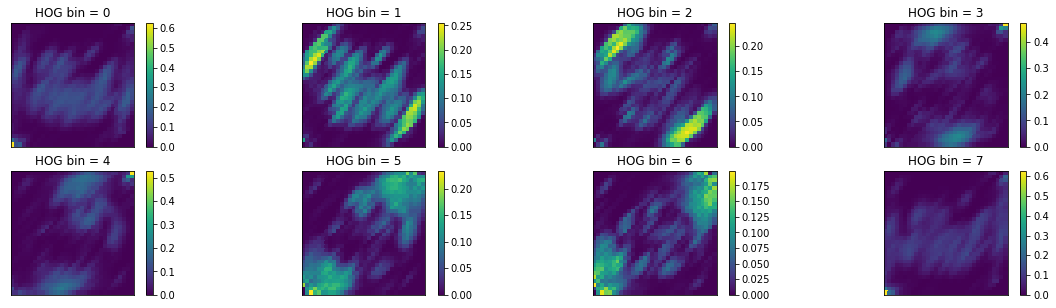

In [11]:
""" Creates a list of HoG features """
def HoG_features(images, cell_size=(4, 4), block_size=(4, 4), nbins=8):
    features = []
    for img in images:
        h, w, _ = img.shape
        c_h, c_w = cell_size
        b_h, b_w = block_size
        
        # create HoG Object
        hog = cv2.HOGDescriptor(_winSize=(w // c_w * c_w, h // c_h * c_h),
                                _blockSize=(b_w * b_w, b_h * b_h),
                                _blockStride=(c_w, c_h),
                                _cellSize=(c_w, c_h),
                                _nbins=nbins)

        n_cells = (h // c_h, w // c_w)

        # compute HoG features
        hog_feats = hog.compute(img) \
                       .reshape(n_cells[1] - b_w + 1, n_cells[0] - b_h + 1, b_h, b_w, nbins) \
                       .transpose((1, 0, 2, 3, 4))  
        
        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(b_h):
            for off_x in range(b_w):
                gradients[off_y:n_cells[0] - b_h + off_y + 1, 
                          off_x:n_cells[1] - b_w + off_x + 1] += hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - b_h + off_y + 1,
                           off_x:n_cells[1] - b_w + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        features.append(gradients)
    return features

# compute features
ford_features = HoG_features(ford_train)
volks_features = HoG_features(volks_train)

# test feature extraction for a single image
feature_test = ford_train[0]
gradients_test = ford_features[0]

# display test feature results
plt.figure(figsize = (7,7))
# plt.subplot(121)
plt.imshow(feature_test)
plt.title("Sample Image"), plt.xticks([]), plt.yticks([])
plt.show()

subplot_shape = 240
plt.figure(figsize=(20, 5))
for i in range(8):
    plt.subplot(subplot_shape + 1 + i)
    plt.pcolor(gradients_test[:, :, i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = {}".format(i)), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

In [12]:
# form feature and label set
train_x = np.array(ford_features + volks_features)
train_x = train_x.reshape(train_x.shape[0], -1)
train_y = ['Ford' for _ in range(len(ford_train))] + ['Volkswagen' for _ in range(len(volks_train))]

# train using knn classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_x, train_y)

print("Model fitted using K-NN Classifier")

Model fitted using K-NN Classifier


#### Part II - Test

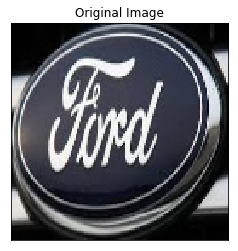

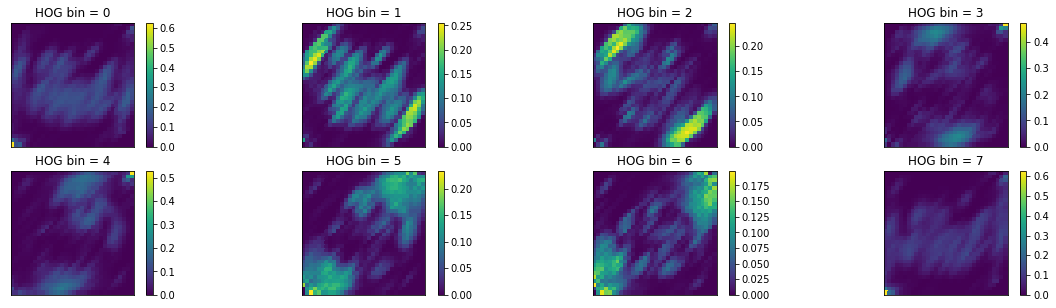

Prediction:  Ford


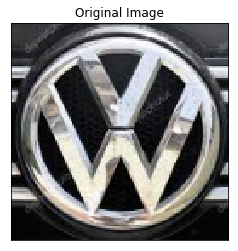

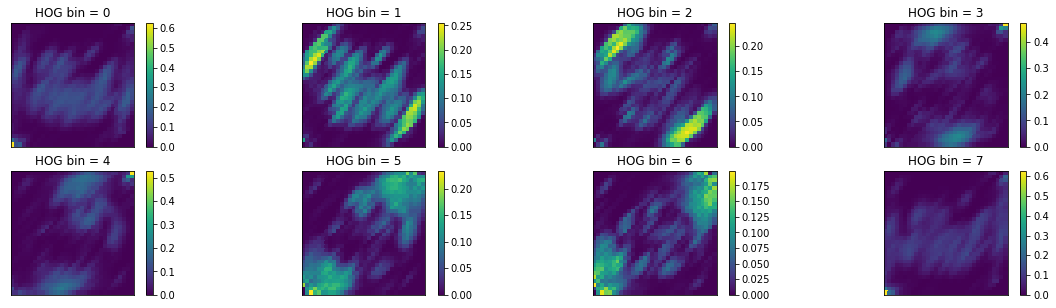

Prediction:  Volkswagen


In [14]:
# make predictions
test_images = ford_test + volks_test
test_x = np.array(HoG_features(test_images))
test_y = model.predict(test_x.reshape(len(test_images), -1))

# display results
for image, x, y in zip(test_images, test_x, test_y):
    plt.figure(figsize = (6,4))
    plt.imshow(image)
    plt.title("Original Image"), plt.xticks([]), plt.yticks([])
    plt.show()
    
    subplot_shape = 240
    plt.figure(figsize=(20, 5))
    for i in range(8):
        plt.subplot(subplot_shape + 1 + i)
        plt.pcolor(gradients_test[:, :, i])
        plt.gca().invert_yaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("HOG bin = {}".format(i)), plt.xticks([]), plt.yticks([])
        plt.colorbar()
    plt.show()
    
    print('Prediction: ', y)

### 3.2 Reasoning Questions

#### 1. Will HoG work if images of logos undergo random rotation? If yes, which property of HoG avails this feature? If not, discuss the sequence of computer vision technique(s) that can be used in order to regain uniform orientation of the logos. 

HoG would not work under rotated images, because it uses gradients to compute intensity changes. Rotations would change the direction of their gradients even though its magnitude would stay the same. We could regain its uniform orientation (in otherwards, restore the origin direction of their gradients) by computing the homography of a reference orientation and its rotated sample, and then apply the appropriate rotation.

#### 2. Consider that you are given a large dataset with three types of images: variable sized squares with either or both diagonals drawn (see Figure 3). How many and which directions of the gradient are suﬃcient in order to correctly classify the images into three categories?

There are only 2 possible diagonals in a square, so we would only need two directions of the gradient in order to correctly classify the images into three categories. When computing the HoG, gradients normal to the diagonal could be created for each line and these gradients could then be used to classify the images.